In [123]:
# load smaller sample of UC Merced dataset, and run the example CIFAR network

### PREAMBLE ################################################################
# allows the images to be displayed in the jupyter notebook
%matplotlib inline

# torch and torchvision related
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# image library
from PIL import Image

# some numeric stuff
import numpy as np
import random
import matplotlib.pyplot as plt

# file input/output libraries
import fnmatch
import os

# datetime
import datetime
now = datetime.datetime.now()

### OPTIONS #################################################################
# may want to later set from command line

# set radom seed
# hm, might need this in every cell where there is a random operation? not 
# sure how notebook works
seedVal = 123;
random.seed(seedVal);

# at which epochs to record training/testing error
epochsConsidered = [5, 10, 25, 50, 100, 150]
saveNetEpochsConsidered = True;

### PATHS ###################################################################

pathTrain = './data/UCMerced_8Classes/train/'
pathTest = './data/UCMerced_8Classes/test/'
pathOutput = './output/'

### FUNCTIONS ###############################################################

# function to compute the percentage accuracy in categorizing images
def computeAccuracy(net, dataSubset):
    correct = 0
    total = 0
    # don't want batches, want to compute over the whole dataset
    dataSubsetLoader = torch.utils.data.DataLoader(dataSubset, num_workers=2)
    for data in dataSubsetLoader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    percentAccuracy = 100 * correct / total
    print('Accuracy of the network is: %d %%' % (
        percentAccuracy))
    
    return(percentAccuracy)

In [124]:
# ### CONVERT IMAGES FROM .tif TO .png ########################################
# # ugly code, should make function rather than copy the same lines of code
# # for Train and Test, as can easily make mistakes

# classes = ['beach', 'forest', 'freeway', 'mediumresidential','agricultural', 'airplane', 'baseballdiamond','buildings']

# for k in range(0,8): ### CAS: change to range(0,8)
#     allTrainFiles = fnmatch.filter(os.listdir(pathTrain+classes[k]), '*.tif');
#     allTestFiles = fnmatch.filter(os.listdir(pathTest+classes[k]), '*.tif');
#     print(k)
#     print(allTrainFiles)
#     for j in range(0,len(allTrainFiles)):
#             img = Image.open(pathTrain+classes[k]+'/'+allTrainFiles[j])
#             newName = os.path.splitext(pathTrain+classes[k]+'/'+allTrainFiles[j])[0]+'.png'
#             img.save(newName)
#     for j in range(0,len(allTestFiles)):
#             img = Image.open(pathTest+classes[k]+'/'+allTestFiles[j])
#             newName = os.path.splitext(pathTest+classes[k]+'/'+allTestFiles[j])[0]+'.png'
#             img.save(newName)

In [125]:
# write what the transforms should be
# From website: Normalize an tensor image with mean and standard deviation. 
# Given mean: (M1,...,Mn)  and std: (S1,..,Sn) for n channels, this transform 
# will normalize each channel of the input
# for some reason resize has to come before ToTensor
transform = transforms.Compose(
    [transforms.Resize(size=32),
     transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load the train and test dataset
#I switch from 4 to 10 on batch_size for both testset and trainsettrainset
trainset = datasets.ImageFolder(root=pathTrain,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,shuffle=True, num_workers=2)

testset = datasets.ImageFolder(root=pathTest, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2)

### CAC classes must be in alphabetical order
classes = ('beach', 'forest', 'freeway', 'mediumresidential','agricultural', 'airplane', 'baseballdiamond','buildings')
classes = sorted(classes) 
print(classes)

['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'forest', 'freeway', 'mediumresidential']


baseballdiamond baseballdiamond buildings mediumresidential mediumresidential agricultural beach baseballdiamond agricultural beach


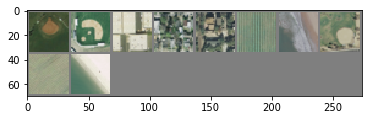

In [126]:
### PRINT IMAGES TO SCREEN TO VISUALIZE ####################################

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(tv.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [127]:
### NETWORK ARCHITECTURE #############################################

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [128]:
# print functions used in the network
net

Net(
  (conv1): Conv2d (3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)

In [129]:
### SET UP TO DETERMINE BEST NUMBER OF EPOCHS (HYPERPARAMETER)
# for each epoch considered, find the training and testing errors
# initialize vectors here
trainErrors = [0]*len(epochsConsidered)
testErrors = [0]*len(epochsConsidered)
count = 0;

In [130]:
### TRAIN NETWORK ######################################################

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### CAS: increased the number of epochs get better result
for epoch in range(max(epochsConsidered)):  # loop over the dataset multiple times 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 5 == 4:    # print every 5 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
    # For selected epochs, compute training and test (see note)
    # acccuracy, and save the network so that it can be reloaded
    if (epoch+1) in epochsConsidered:
        trainErrors[count] = computeAccuracy(net, trainset)
        ### !!! NEVER EVER USE TESTING DATA TO DETERMINE A HYPERPARAMETER !!!
        ### This is here for illustration.
        ### We can use the "elbow" in the training data or do cross-validation
        ### later.
        testErrors[count] = computeAccuracy(net, testset)
        count = count + 1
        # save networks at the different epochs, to later load
        if (saveNetEpochsConsidered):
            saveFilename = str(now.strftime("%Y-%m-%d")) + ('Original%s_epochs.pth' % (epoch+1))
            savePath = os.path.join(pathOutput, 'networks', saveFilename)
            torch.save(net.cpu().state_dict(), savePath)
        
print('Finished Training')

[1,     5] loss: 0.006
[1,    10] loss: 0.006
[1,    15] loss: 0.006
[1,    20] loss: 0.006
[1,    25] loss: 0.006
[1,    30] loss: 0.006
[1,    35] loss: 0.006
[1,    40] loss: 0.006
[1,    45] loss: 0.006
[1,    50] loss: 0.006
[1,    55] loss: 0.006
[1,    60] loss: 0.006
[1,    65] loss: 0.006
[1,    70] loss: 0.006
[2,     5] loss: 0.006
[2,    10] loss: 0.006
[2,    15] loss: 0.006
[2,    20] loss: 0.006
[2,    25] loss: 0.006
[2,    30] loss: 0.006
[2,    35] loss: 0.006
[2,    40] loss: 0.006
[2,    45] loss: 0.006
[2,    50] loss: 0.006
[2,    55] loss: 0.006
[2,    60] loss: 0.006
[2,    65] loss: 0.006
[2,    70] loss: 0.006
[3,     5] loss: 0.006
[3,    10] loss: 0.006
[3,    15] loss: 0.006
[3,    20] loss: 0.006
[3,    25] loss: 0.006
[3,    30] loss: 0.006
[3,    35] loss: 0.006
[3,    40] loss: 0.006
[3,    45] loss: 0.006
[3,    50] loss: 0.006
[3,    55] loss: 0.006
[3,    60] loss: 0.006
[3,    65] loss: 0.006
[3,    70] loss: 0.006
[4,     5] loss: 0.006
[4,    10] 

[25,    35] loss: 0.003
[25,    40] loss: 0.002
[25,    45] loss: 0.002
[25,    50] loss: 0.002
[25,    55] loss: 0.003
[25,    60] loss: 0.002
[25,    65] loss: 0.002
[25,    70] loss: 0.003
Accuracy of the network is: 69 %
Accuracy of the network is: 61 %
[26,     5] loss: 0.002
[26,    10] loss: 0.002
[26,    15] loss: 0.002
[26,    20] loss: 0.002
[26,    25] loss: 0.002
[26,    30] loss: 0.003
[26,    35] loss: 0.002
[26,    40] loss: 0.002
[26,    45] loss: 0.003
[26,    50] loss: 0.002
[26,    55] loss: 0.003
[26,    60] loss: 0.002
[26,    65] loss: 0.002
[26,    70] loss: 0.002
[27,     5] loss: 0.002
[27,    10] loss: 0.002
[27,    15] loss: 0.002
[27,    20] loss: 0.003
[27,    25] loss: 0.002
[27,    30] loss: 0.002
[27,    35] loss: 0.002
[27,    40] loss: 0.002
[27,    45] loss: 0.002
[27,    50] loss: 0.002
[27,    55] loss: 0.002
[27,    60] loss: 0.002
[27,    65] loss: 0.002
[27,    70] loss: 0.002
[28,     5] loss: 0.002
[28,    10] loss: 0.002
[28,    15] loss: 0.00

[49,    55] loss: 0.001
[49,    60] loss: 0.001
[49,    65] loss: 0.001
[49,    70] loss: 0.001
[50,     5] loss: 0.000
[50,    10] loss: 0.001
[50,    15] loss: 0.000
[50,    20] loss: 0.000
[50,    25] loss: 0.000
[50,    30] loss: 0.000
[50,    35] loss: 0.001
[50,    40] loss: 0.000
[50,    45] loss: 0.000
[50,    50] loss: 0.001
[50,    55] loss: 0.000
[50,    60] loss: 0.001
[50,    65] loss: 0.001
[50,    70] loss: 0.000
Accuracy of the network is: 92 %
Accuracy of the network is: 77 %
[51,     5] loss: 0.001
[51,    10] loss: 0.001
[51,    15] loss: 0.000
[51,    20] loss: 0.000
[51,    25] loss: 0.001
[51,    30] loss: 0.000
[51,    35] loss: 0.000
[51,    40] loss: 0.001
[51,    45] loss: 0.001
[51,    50] loss: 0.001
[51,    55] loss: 0.000
[51,    60] loss: 0.000
[51,    65] loss: 0.000
[51,    70] loss: 0.000
[52,     5] loss: 0.000
[52,    10] loss: 0.000
[52,    15] loss: 0.000
[52,    20] loss: 0.000
[52,    25] loss: 0.000
[52,    30] loss: 0.000
[52,    35] loss: 0.00

[74,     5] loss: 0.000
[74,    10] loss: 0.000
[74,    15] loss: 0.000
[74,    20] loss: 0.000
[74,    25] loss: 0.000
[74,    30] loss: 0.000
[74,    35] loss: 0.000
[74,    40] loss: 0.000
[74,    45] loss: 0.000
[74,    50] loss: 0.000
[74,    55] loss: 0.000
[74,    60] loss: 0.000
[74,    65] loss: 0.000
[74,    70] loss: 0.000
[75,     5] loss: 0.000
[75,    10] loss: 0.000
[75,    15] loss: 0.000
[75,    20] loss: 0.000
[75,    25] loss: 0.001
[75,    30] loss: 0.000
[75,    35] loss: 0.001
[75,    40] loss: 0.000
[75,    45] loss: 0.000
[75,    50] loss: 0.000
[75,    55] loss: 0.000
[75,    60] loss: 0.001
[75,    65] loss: 0.000
[75,    70] loss: 0.000
[76,     5] loss: 0.001
[76,    10] loss: 0.001
[76,    15] loss: 0.001
[76,    20] loss: 0.001
[76,    25] loss: 0.001
[76,    30] loss: 0.000
[76,    35] loss: 0.001
[76,    40] loss: 0.000
[76,    45] loss: 0.000
[76,    50] loss: 0.000
[76,    55] loss: 0.000
[76,    60] loss: 0.000
[76,    65] loss: 0.000
[76,    70] loss

[98,    35] loss: 0.000
[98,    40] loss: 0.000
[98,    45] loss: 0.000
[98,    50] loss: 0.000
[98,    55] loss: 0.000
[98,    60] loss: 0.000
[98,    65] loss: 0.000
[98,    70] loss: 0.000
[99,     5] loss: 0.000
[99,    10] loss: 0.000
[99,    15] loss: 0.000
[99,    20] loss: 0.000
[99,    25] loss: 0.000
[99,    30] loss: 0.000
[99,    35] loss: 0.000
[99,    40] loss: 0.000
[99,    45] loss: 0.000
[99,    50] loss: 0.000
[99,    55] loss: 0.000
[99,    60] loss: 0.000
[99,    65] loss: 0.000
[99,    70] loss: 0.000
[100,     5] loss: 0.000
[100,    10] loss: 0.000
[100,    15] loss: 0.000
[100,    20] loss: 0.000
[100,    25] loss: 0.000
[100,    30] loss: 0.000
[100,    35] loss: 0.000
[100,    40] loss: 0.000
[100,    45] loss: 0.000
[100,    50] loss: 0.000
[100,    55] loss: 0.000
[100,    60] loss: 0.000
[100,    65] loss: 0.000
[100,    70] loss: 0.000
Accuracy of the network is: 99 %
Accuracy of the network is: 78 %
Finished Training


In [134]:
# Sanity check: printing out testing errors to see
testErrors

[22.5, 20.0, 61.25, 77.5, 78.75]

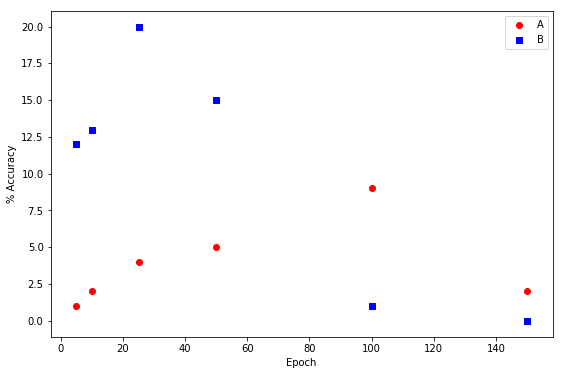

In [135]:
### FIGURE TO SHOW TRAIN AND TEST ERROR ############################
# !!! This needs to be edited to show the training and testing error plot 
a = [5, 10, 25, 50, 100, 150]
b = [1, 2, 4, 5, 9, 2]
c = [12, 13, 20, 15, 1, 0]

# initialize figure
plt.figure(figsize=(9, 6)) 

# the two scatter grap data sets
data1 = plt.scatter(a, b, color='r', marker='o', label='A')
data2 = plt.scatter(a, c, color='b', marker='s', label='B')

# formatting
plt.xlabel('Epoch')
plt.ylabel('% Accuracy')
plt.legend()

# save to file
fig = plt.gcf()
fig.savefig(pathOutput + str(now.strftime("%Y-%m-%d")) + 
            '-Train-Test-Error.png', bbox_inches="tight")

In [136]:
# Check that you can load a previous network
# !!! This loads the saved network into the variable net, overwritting net !!!
# But the last saved net can be reloaded!
fileToLoad = '2018-01-21Original25_epochs.pth'
net.load_state_dict(torch.load(os.path.join(pathOutput, 'networks', fileToLoad)))
computeAccuracy(net, testset)

Accuracy of the network is: 61 %


61.25